<a href="https://colab.research.google.com/github/thiagolages/DCC831-deep-learning-algorithms/blob/master/05_AE_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising autoencoder como regularizador

Vamos mostrar como aprender a estrutura de um autoencoder que faz denoising.
O autoencoder será do tipo CNN com algumas camadas. Ele terá um regularizador zerando alguns nós na camada CODE. Veja as notas de aula.

Fica como exercício criar um dataset acrescentando um ruído "estruturado" nas imagens 28x28 do MNIST imitando uma marca d'água. Por exemplo, imagine que a marca d'água será um conjunto 4 x 6 de pixels. Escolha uma posição numa buffer
que impeça a marca d'água sair da imagem. A marca deverá apenas um conjunto de pixels dentro do retângulo 4 x 6 que crie uma imagem distinta (uma cruz, por exemplo). Se você quiser ser criativo, fique a vontade. Por exemplo, usando marcas mais legais e usando um banco de imagens menos simples.

In [1]:
import sys
sys.executable

'/usr/bin/python3'

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.datasets import mnist
import keras
import numpy as np
import matplotlib.pyplot as plt

# o regularizador na acamada CODE precisa do módulo regularizers
from keras import regularizers

2024-12-01 23:05:28.972938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 23:05:28.982618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733105128.994029  863392 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733105128.997063  863392 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 23:05:29.007959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Load MNIST

(x_train, _), (x_test, _) = mnist.load_data()

# Scaling the values to be floats between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
# Define initials (TL) function
def add_initials(x, x_offset: int = 1, y_offset: int = 1, width: int = 6, height: int = 4):
    def add_TL(x):
        # adding 'TL' 
        x[:,1] = 1.0 # 'T' vertical body
        x[:,3] = 1.0 # 'L' vertical body
        # remaining pixels
        x[0,0] = x[0,2] = x[3,4] = x[3,5] = 1.0
        return x

    roi = x[x_offset:x_offset+height, y_offset:y_offset+width]
    roi = add_TL(roi)
        
    return x

In [5]:
# def add_TL(x):
#     # adding 'TL' 
#     x[:,1] = 1.0 # 'T' vertical body
#     x[:,3] = 1.0 # 'L' vertical body
#     # remaining pixels
#     x[0,0] = x[0,2] = x[3,4] = x[3,5] = 1.0
#     return x
# x = np.zeros((4, 6))
# add_TL(x)
# print(x)

# x = np.ones((28,28))
# x_offset= 1
# y_offset= 1
# width= 6
# height= 4
# print(x[x_offset:x_offset+height, y_offset:y_offset+width].shape)
# #print(x[x_offset:x_offset+height, y_offset:y_offset+width])
# roi = x[x_offset:x_offset+height, y_offset:y_offset+width]
# print(roi.shape)
# x = add_initials(x)
# print(x.shape)

In [6]:
# Add initials to data
import numpy as np
un = np.random.uniform
n = x_train.shape[0]
x_train = np.array([add_initials(x, x_offset=int(xo), y_offset=int(yo)) for x, xo, yo in zip(x_train,un(0,28-6,n),un(0,28-6,n))])
x_test = np.array([add_initials(x, x_offset=int(xo), y_offset=int(yo)) for x, xo, yo in zip(x_test,un(0,28-6,n),un(0,28-6,n))])

# Replace noisy data with initials data
x_train_noisy = x_train
x_test_noisy = x_test

In [7]:
# # Adding Gaussian noise N(0, 0.25) at each pixel  (we add 0.5*N(0.1) = N(0, 0.5**2))
# noise_factor = 0.5
# x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
# x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# # clipping to assure that the noisy values are between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

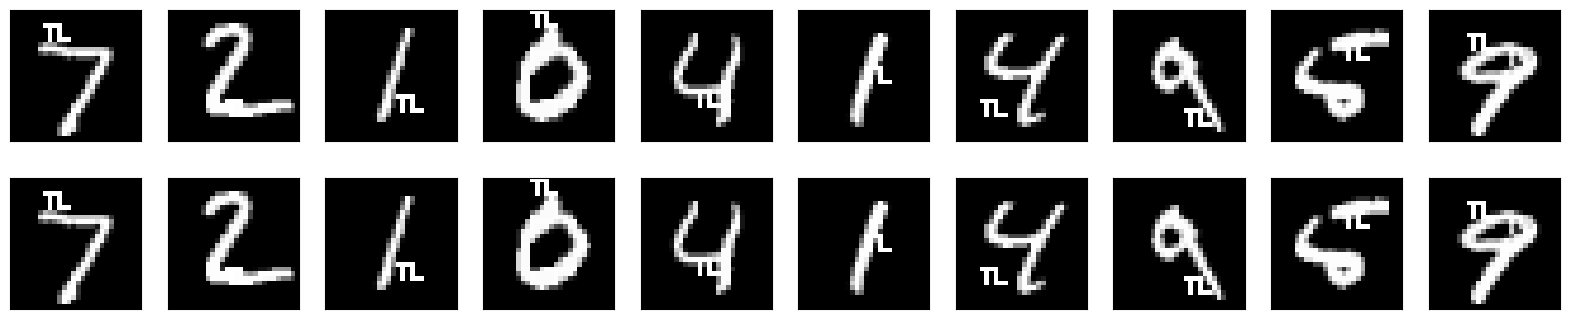

In [8]:
# Visualizing the noisy values

n = 10   # How many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the noisy version
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
input = Input(shape=(28,28,1), name='entrada')
conv = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', name='conv_1')
x = conv(input)
maxp = MaxPooling2D(pool_size=(2,2), padding='same')
x = maxp(x)
# demais camadas, usando callable layers
x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',name='conv_2')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',
                  name='conv_3', activity_regularizer=regularizers.l1(10e-5))(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# Vamos agora especificar os nós do grafo de camadas associados com o decoder
x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',
                  name='conv_4')(x)
x = UpSampling2D(size=(2,2))(x)
# Demais camadas
x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',name='conv_5')(x)
x = UpSampling2D(size=(2,2))(x)

x = Conv2D(filters=8, kernel_size=(3,3), activation='relu',name='conv_6')(x)
x = UpSampling2D(size=(2,2))(x)

output = Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid', name='output')(x)

autoencoder = Model(inputs= input, outputs=output, name='CAE')
autoencoder.summary()

I0000 00:00:1733105131.377880  863392 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5395 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "CAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 7, 7, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (None, 28, 28, 1)      │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,729 (14.57 KB)

 Trainable params: 3,729 (14.57 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile o modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
# Treinando o modelo
autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=256)

Epoch 1/15


I0000 00:00:1733105135.304638  863543 service.cc:148] XLA service 0x7f2f8c015a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733105135.304677  863543 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-01 23:05:35.339718: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733105135.512672  863543 cuda_dnn.cc:529] Loaded cuDNN version 90300


 40/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9843

I0000 00:00:1733105137.782288  863543 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.6040
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3001
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2713
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2575
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2475
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2403
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2348
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2302
Epoch 9/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2254
Epoch 10/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2219
Epoch 11/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2190
Epoch 12/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2156
Epoch 13/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2131
Epoch 14/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2082
Epoch 15/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2036

In [12]:
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


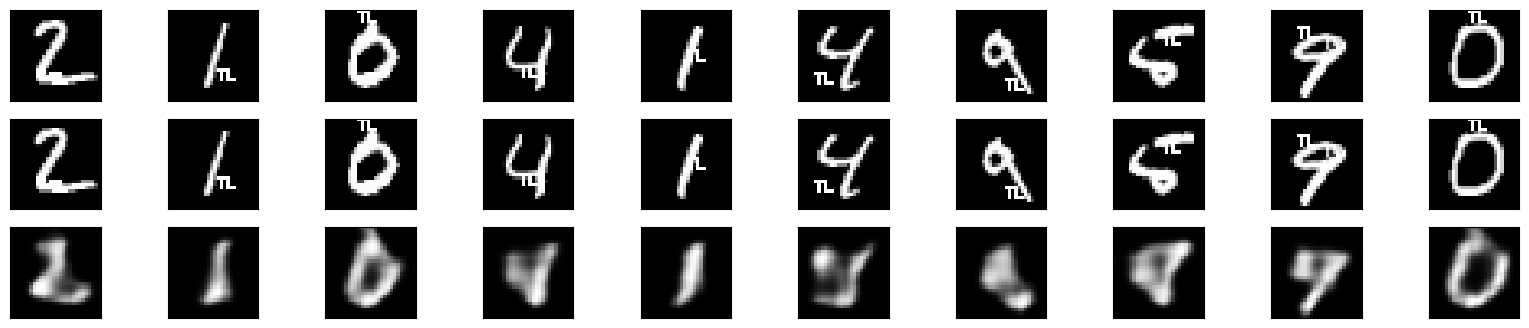

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))  # imagens originais, sem ruído
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy test images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()